# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works better than Euler Deconvolution. It will show how the solution converges. This is also the first synthetic that will be shown in the paper.

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create a model and data

Number of data: 5712


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


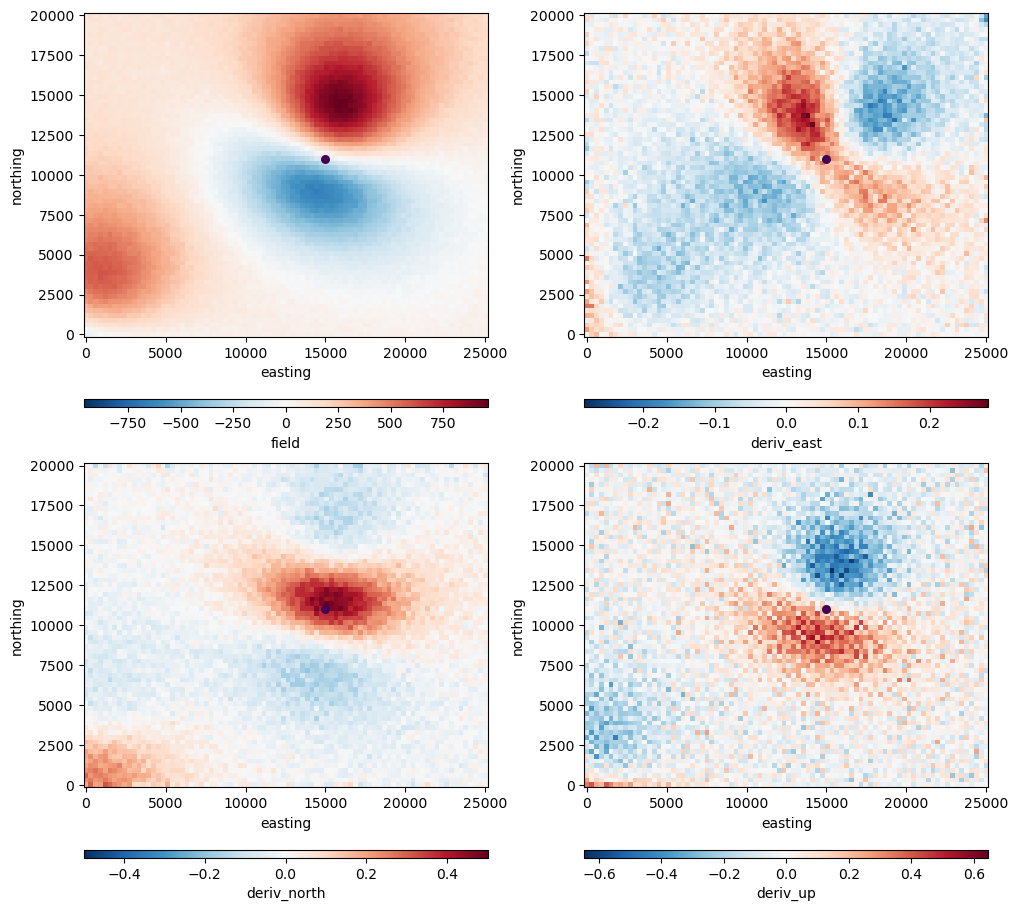

In [8]:
region = [0, 25e3, 0, 20e3]
coordinates = vd.grid_coordinates(region, spacing=300, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Interfering source
other = hm.dipole_magnetic(
    coordinates, 
    dipoles=(0e3, 0e3, -6e3),
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(other, main_field))

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Deconvolution

In [9]:
%%time
ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ed.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ed.source_location_}")

Base level:
  True      = 100
  Estimated = 132.92424784874703
Position:
  True      = (15000.0, 11000.0, -5000.0)
  Estimated = [13378.66795268  9964.96498163 -3227.0019466 ]
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 9.94 ms


## Euler Inversion

In [10]:
%%time
ei = euler.EulerInversion(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.source_location_}")

Base level:
  True      = 100
  Estimated = 132.95527219894294
Position:
  True      = (15000.0, 11000.0, -5000.0)
  Estimated = [14707.84687058 10689.6528518  -5042.80090989]
CPU times: user 26 s, sys: 23.8 ms, total: 26 s
Wall time: 18.8 s


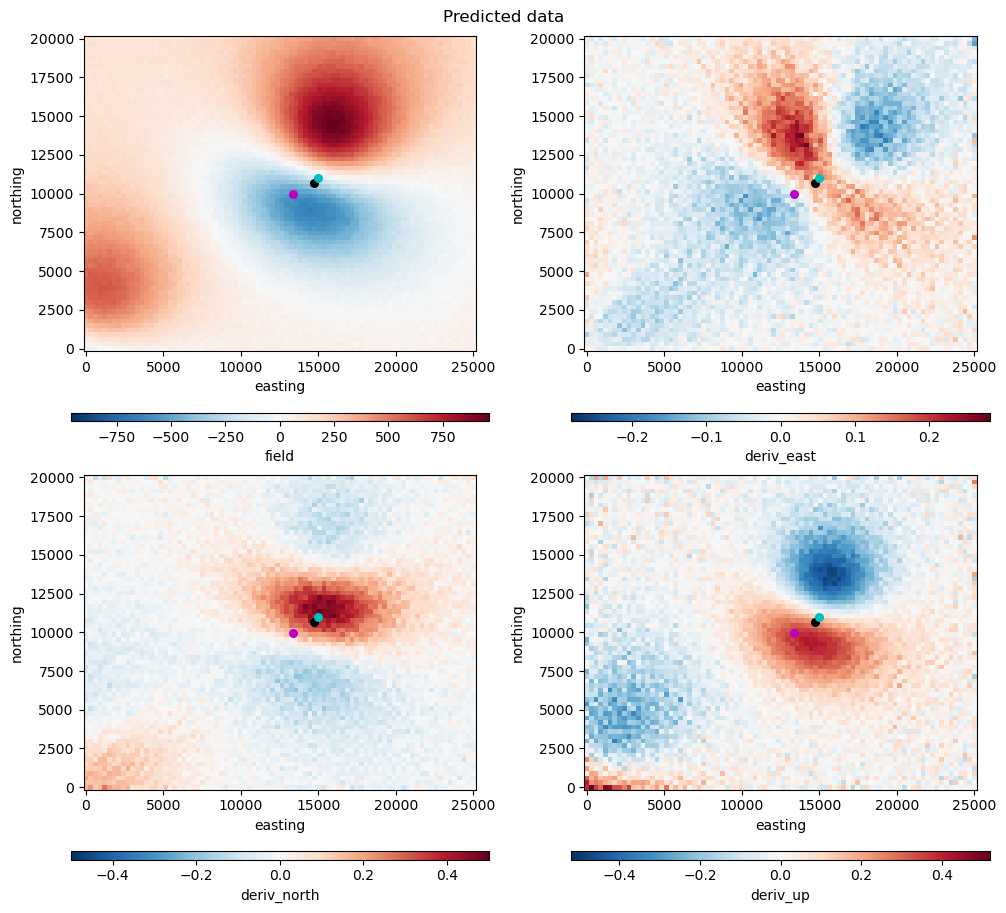

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    ei.predicted_grids_[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*ei.source_location_[:2], c="k", s=30)
    tmp = ax.scatter(*ed.source_location_[:2], c="m", s=30)
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
fig.suptitle("Predicted data")
plt.show()

## Show the process per iteration

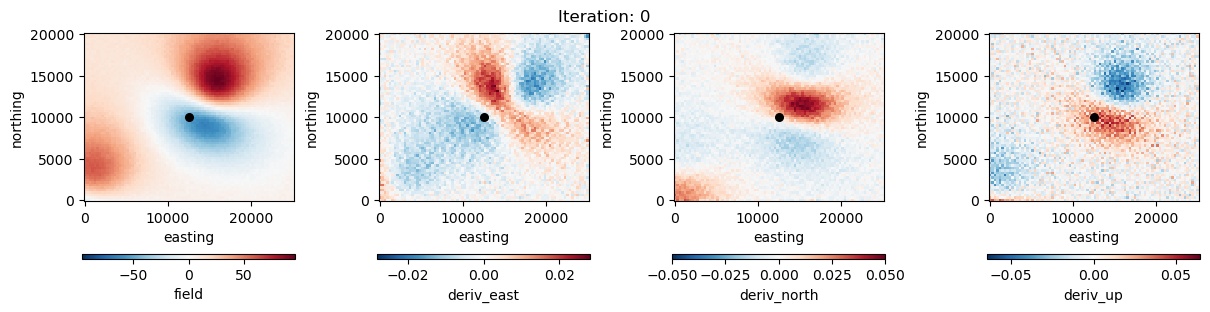

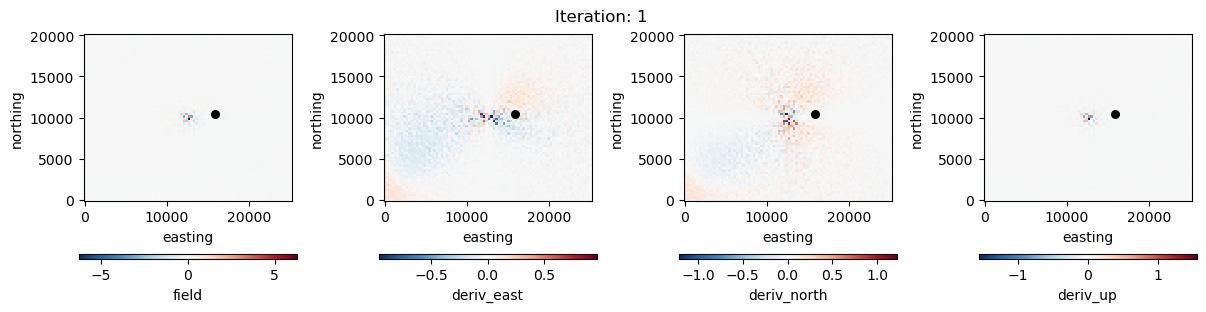

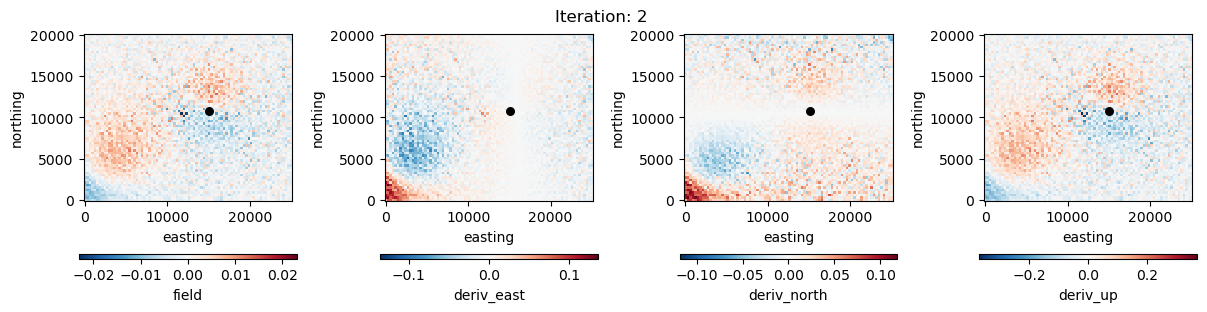

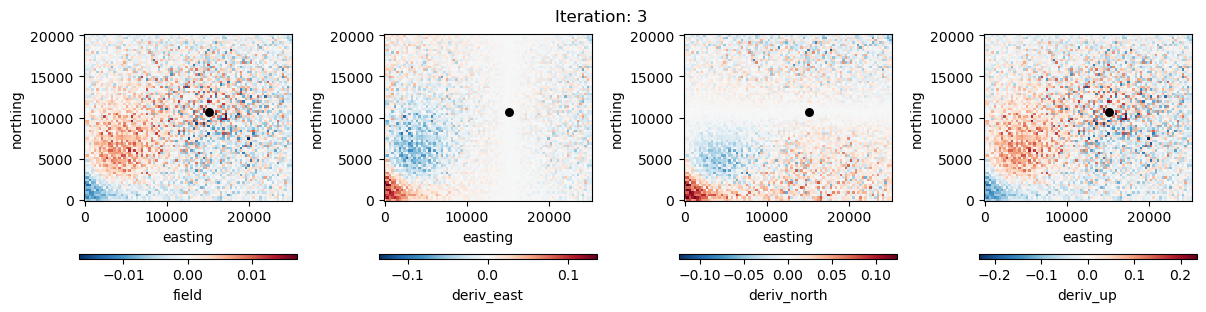

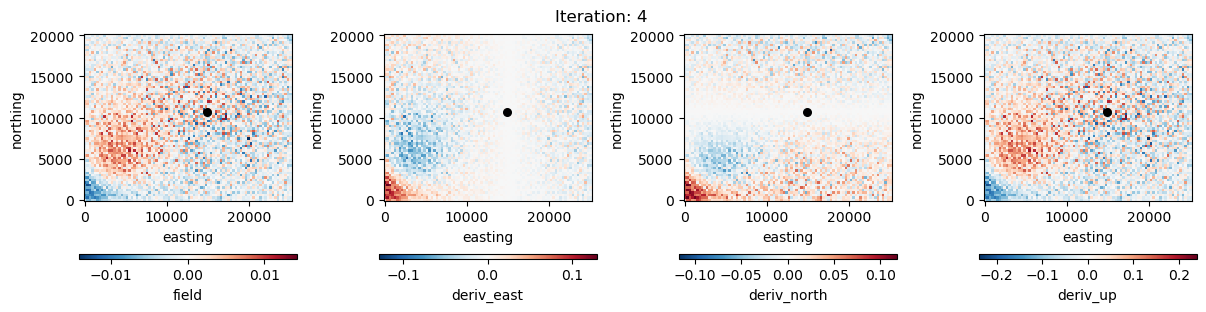

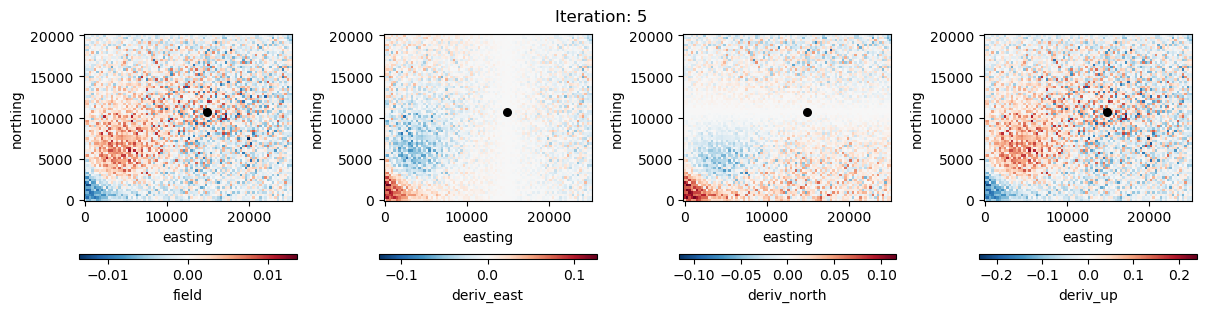

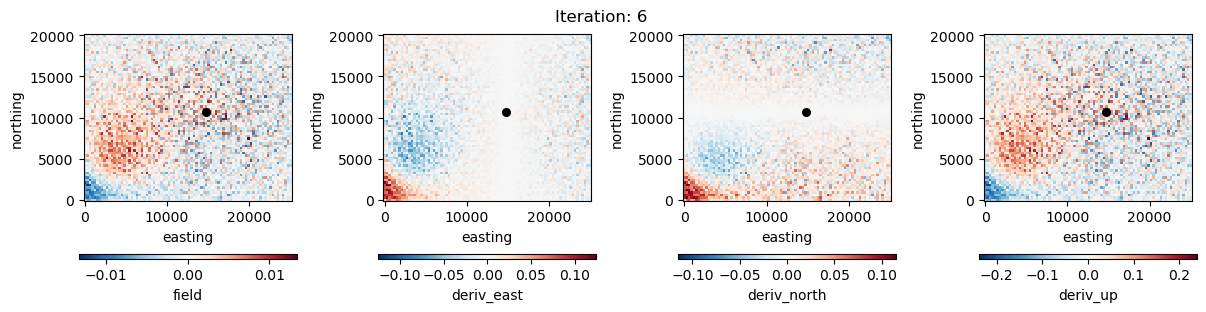

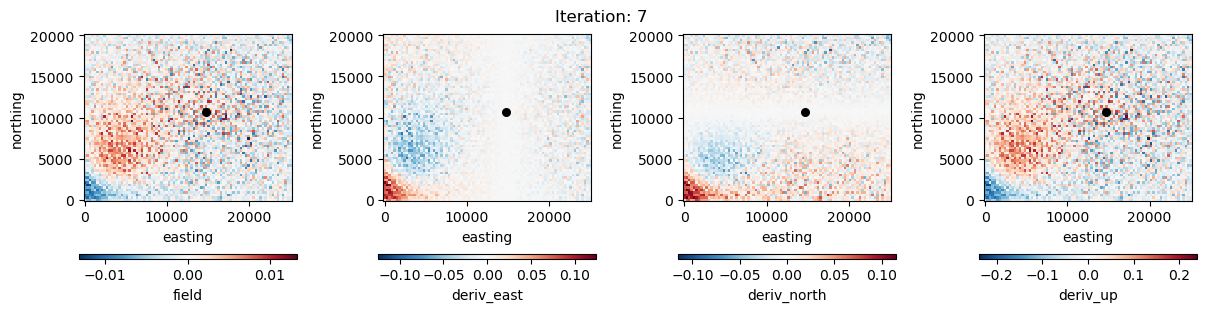

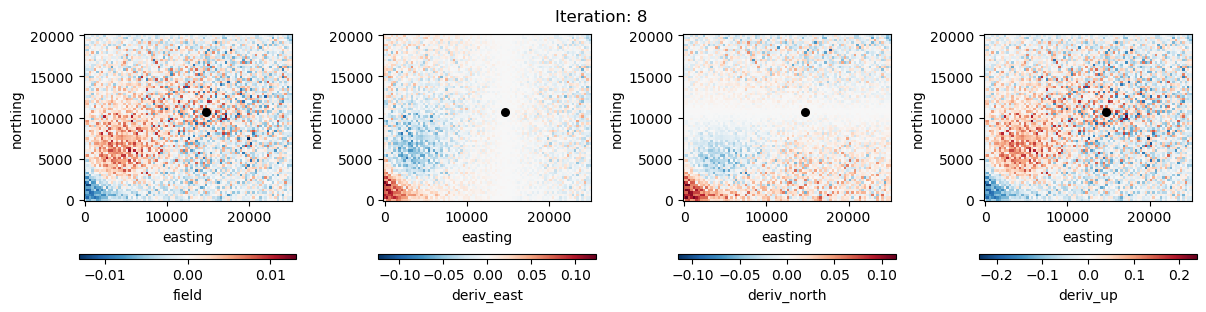

In [12]:
estimates = []
base_levels = []
ei = euler.EulerInversion(structural_index=3)
for i, _ in enumerate(ei.fit_grid_iterator(data.field, data.deriv_east, data.deriv_north, data.deriv_up)):
    estimates.append(ei.source_location_.copy())
    base_levels.append(ei.base_level_)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3), layout='constrained')
    for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
        (data[field] - ei.predicted_grids_[field]).plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
        ax.set_aspect("equal")
        ax.scatter(*ei.source_location_[:2], c="k", s=30)
    fig.suptitle(f"Iteration: {i}")
    plt.show()
    plt.close()

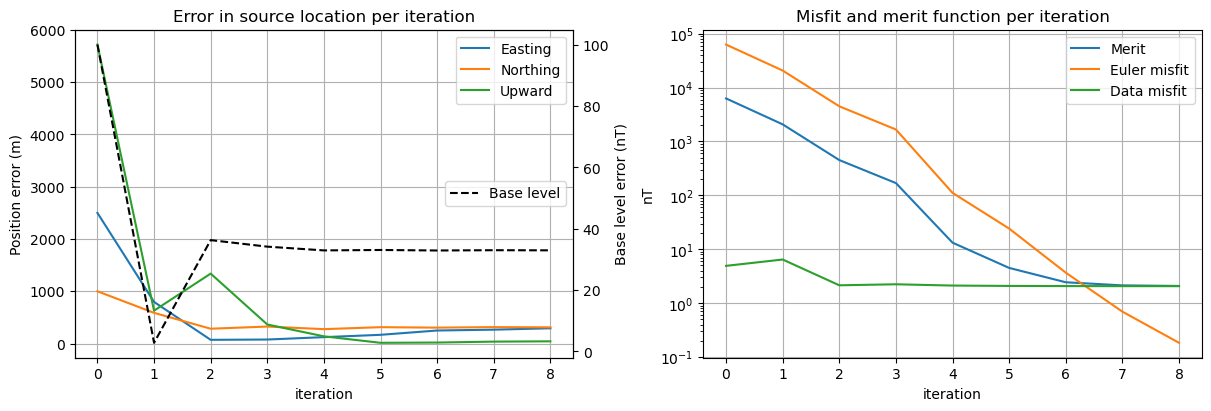

In [13]:
estimates = np.array(estimates)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(base_levels)
base_error = np.abs(base_level - base_levels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")

ax1.plot(east_error, label="Easting")
ax1.plot(north_error, label="Northing")
ax1.plot(up_error, label="Upward")
ax1.legend()
twin = ax1.twinx()
twin.plot(base_error, "k--", label="Base level")
twin.set_ylabel("Base level error (nT)")
twin.legend(loc="center right")
ax1.grid()
ax1.set_xlabel("iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in source location per iteration")

ax2.plot(ei.merit_, label="Merit")
ax2.plot(ei.euler_misfit_, label="Euler misfit")
ax2.plot(ei.data_misfit_, label="Data misfit")
ax2.legend()
ax2.set_yscale("log")
ax2.grid()
ax2.set_xlabel("iteration")
ax2.set_ylabel("nT")
ax2.set_title("Misfit and merit function per iteration")

plt.show()